<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous allons donner une définition novice de la sinistralité, et nous allons implémenter différents algorithmes prédictifs pour prédire la sinistralité pour 2025.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Définition de la sinistralité</b></h2>

<p style="font-family: Arial, sans-serif; font-size: 20px; color:white;">
En nous inspirant de la bibliographie 2, nous allons utiliser la définition suivante de la dérive de sinistralité :
</p>

$$
\text{dérive de sinistralité(N/N-1)} = \frac{RAC_{N}}{RAC_{N-1}} -1\\

\text{où $RAC_{N}$ est le reste à charge estimé de l'année N, par reste à charge nous signifions le montant des prestations de santé après déduction du remboursement de la sécurité sociale.}\\

$$


<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Nous allons alors nous intéresser à la prédiction du reste à charge qui nous donnera la dérive de sinistralité pour l'année 2025.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données et leurs visualisations</b></h2>

In [184]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = pd.read_csv("../../page 3/RAC_nouveau.csv")

In [185]:
df.head()

,FLX_ANN_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,201901.0,2.0,70.0,5.0,4175537.69,2.538271e+07,2.120717e+07
1,201901.0,2.0,80.0,24.0,7357488.44,3.480094e+07,2.744345e+07
2,201901.0,1.0,0.0,52.0,9717960.12,2.445639e+07,1.473843e+07
3,201901.0,2.0,60.0,5.0,5179146.18,2.548382e+07,2.030468e+07
4,201901.0,1.0,40.0,52.0,6926479.09,2.127533e+07,1.434885e+07


In [186]:
df = df.astype({
    'FLX_ANN_MOI': 'str',
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32'
})
df['annee'] = df['FLX_ANN_MOI'].str[: 4].astype('int32')
df['mois'] = df['FLX_ANN_MOI'].str[4: 6].astype('int32')
df.drop(columns=['FLX_ANN_MOI'], inplace=True)
df.head()

,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT,annee,mois
0,2,70,5,4175537.69,2.538271e+07,2.120717e+07,2019,1
1,2,80,24,7357488.44,3.480094e+07,2.744345e+07,2019,1
2,1,0,52,9717960.12,2.445639e+07,1.473843e+07,2019,1
3,2,60,5,5179146.18,2.548382e+07,2.030468e+07,2019,1
4,1,40,52,6926479.09,2.127533e+07,1.434885e+07,2019,1


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Filtrage des données</b></h2>

On enlève les valeurs inconnues pour le sexe et l'âge et on ne garde que les données agrégés mensuellement

In [187]:

df.rename(columns = {'AGE_BEN_SNDS': 'age', 'BEN_RES_REG': 'region', 'BEN_SEX_COD': 'sexe', 'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM'}, inplace = True)

df_grouped = df.drop(columns = ['PAI', 'REM', 'mois']).groupby(by = ['annee', 'age', 'sexe', 'region']).sum()

df_grouped.reset_index(inplace=True)

df_grouped


,annee,age,sexe,region,RAC
0,2019,0,1,5,4.019677e+07
1,2019,0,1,11,4.481693e+08
2,2019,0,1,24,6.655017e+07
3,2019,0,1,27,6.983353e+07
4,2019,0,1,28,8.899951e+07
...,...,...,...,...,...
1243,2024,80,2,53,1.318653e+08
1244,2024,80,2,75,2.787899e+08
1245,2024,80,2,76,2.884771e+08
1246,2024,80,2,84,3.230232e+08


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création d'un champ population</b></h2>

In [188]:
years = df_grouped['annee'].unique()
age_mapping = {'0-19' : 0, '20-29' : 20, '30-39' : 30, '40-49' : 40, '50-59' : 50, '60-69' : 60, '70-79' : 70, '80+' : 80}
reversed_age_mapping = {v: k for k, v in age_mapping.items()}
year_population_dataframes = {}
for year in years:
    print(f"Dataframe crée pour l'année {year}")
    df_year = pd.read_csv(f"../../CSV demographie/population {year} agrégée.csv", sep=';')
    df_year = df_year.rename(columns={"Tranche d'Âge": 'age'})
    df_long = df_year.melt(var_name='sexe', value_name='population', id_vars=('age'))
    df_long['sexe'] = df_long['sexe'].map({'Hommes': 1, 'Femmes': 2})
    df_long['age'] = df_long['age'].map(age_mapping)
    df_long['annee'] = year
    year_population_dataframes[year] = df_long


Dataframe crée pour l'année 2019
Dataframe crée pour l'année 2020
Dataframe crée pour l'année 2021
Dataframe crée pour l'année 2022
Dataframe crée pour l'année 2023
Dataframe crée pour l'année 2024


In [189]:
# on va merge les dataframes
merged_dfs = {}
for year, df_year in year_population_dataframes.items():
    copied_df = df_grouped.copy()
    # Merge the dataframes on 'annee', 'age', and 'sexe'
    copied_df = copied_df.merge(df_year, how='right', on=['annee', 'age', 'sexe'], suffixes=('', '_new'))

    merged_dfs[year] = copied_df
final_df = pd.concat(merged_dfs.values(), ignore_index=True)
final_df['age'] = final_df['age'].map(reversed_age_mapping)


final_df

,annee,age,sexe,region,RAC,population
0,2019,0-19,1,5,4.019677e+07,8225000
1,2019,0-19,1,11,4.481693e+08,8225000
2,2019,0-19,1,24,6.655017e+07,8225000
3,2019,0-19,1,27,6.983353e+07,8225000
4,2019,0-19,1,28,8.899951e+07,8225000
...,...,...,...,...,...,...
1243,2024,80+,1,53,7.109946e+07,1554000
1244,2024,80+,1,75,1.675697e+08,1554000
1245,2024,80+,1,76,1.707322e+08,1554000
1246,2024,80+,1,84,1.967512e+08,1554000


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Visualisation du reste à charge</b></h2>

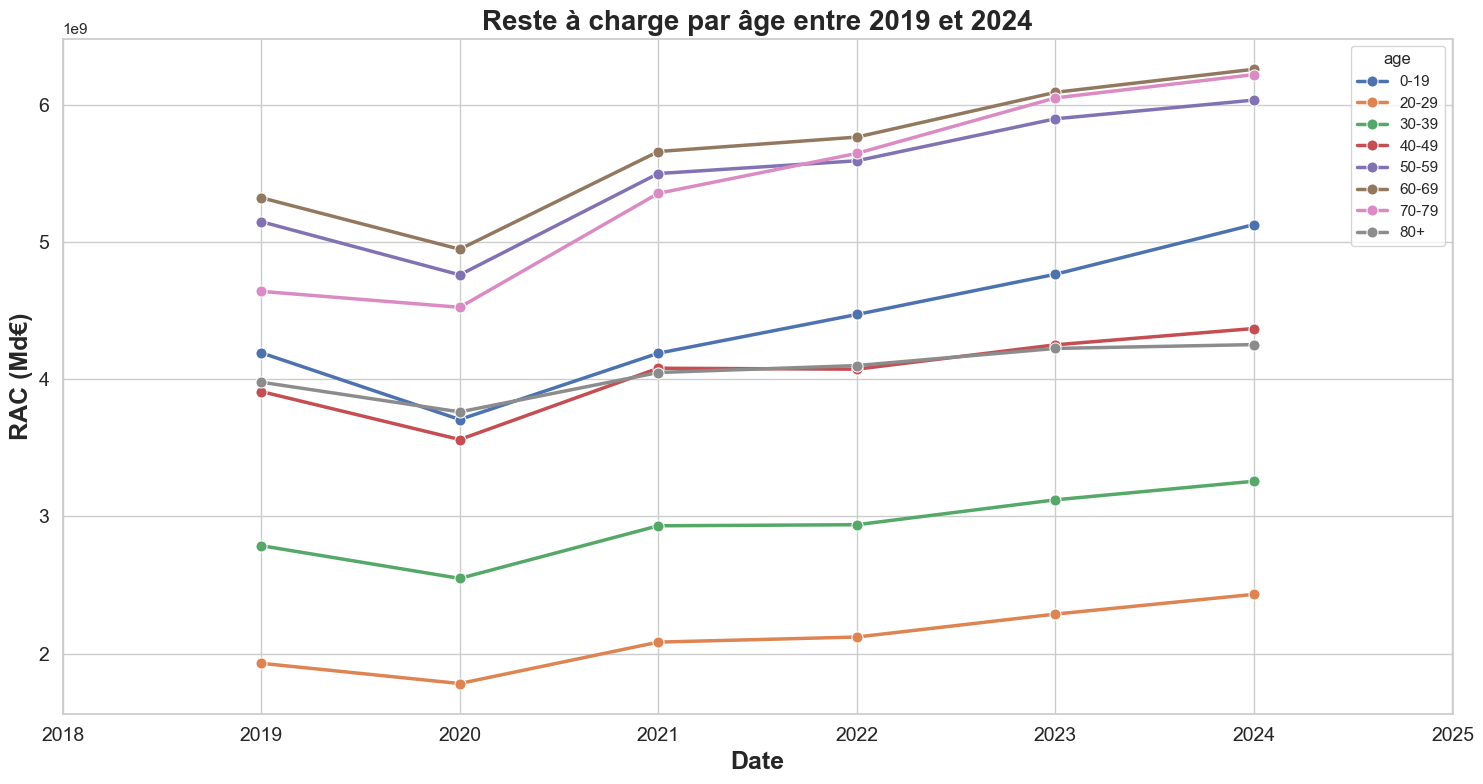

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

sns.lineplot(x="annee", y="RAC", data=final_df, hue="age", marker='o', markersize=8, linewidth=2.5, errorbar=None, estimator=np.sum)

# Title with bigger font
plt.title("Reste à charge par âge entre 2019 et 2024", fontsize=20, fontweight='bold')

# Axis labels with bigger font
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("RAC (Md€)", fontsize=18, fontweight='bold')

# Optional: Ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(2018, 2025)

plt.tight_layout()
plt.show()



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création de la base de données de dérive de sinistralité</b></h2>

In [191]:

new_work_age_mapping = {'0-19' : '0-19', '20-29' : '20-59', '30-39' : '20-59', '40-49' : '20-59', '50-59' : '20-59', '60-69' : '60+', '70-79' : '60+', '80+' : '60+'}
derive_dfs = []
def get_all_data_beginning_from_year(current_year): 
    derive_dfs = []
    for year, df_year_ in merged_dfs.items():
        # Calculate the population growth rate for each age group
        if year > current_year:
            df_year = df_year_.copy()
            precedent_df_year = merged_dfs[year - 1].copy()
            df_year.sort_values(by=['age', 'sexe'], inplace=True)
            precedent_df_year.sort_values(by=['age', 'sexe'], inplace=True)
            precedent_df_year['age'] = precedent_df_year['age'].map(reversed_age_mapping)
            df_year['age'] = df_year['age'].map(reversed_age_mapping)
            precedent_df_year['age'] = precedent_df_year['age'].map(new_work_age_mapping)
            df_year['age'] = df_year['age'].map(new_work_age_mapping)
            df_year = df_year.groupby(['annee', 'age', 'sexe', 'region']).sum().reset_index()
            precedent_df_year = precedent_df_year.groupby(['annee', 'age', 'sexe','region']).sum().reset_index()
            df_year['dérive'] = df_year['RAC'] / precedent_df_year['RAC'] - 1
            derive_dfs.append(df_year[['annee', 'age', 'sexe','region', 'population', 'dérive']])
        
    Derive_df = pd.concat(derive_dfs, ignore_index=True)
    return Derive_df
get_all_data_beginning_from_year(2020)

,annee,age,sexe,region,population,dérive
0,2021,0-19,1,5,8220000,0.123818
1,2021,0-19,1,11,8220000,0.152188
2,2021,0-19,1,24,8220000,0.137131
3,2021,0-19,1,27,8220000,0.118739
4,2021,0-19,1,28,8220000,0.130836
...,...,...,...,...,...,...
307,2024,60+,2,53,10648000,0.031034
308,2024,60+,2,75,10648000,0.033448
309,2024,60+,2,76,10648000,0.015359
310,2024,60+,2,84,10648000,0.024973


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Visualisation de la dérive de sinistralité</b></h2>

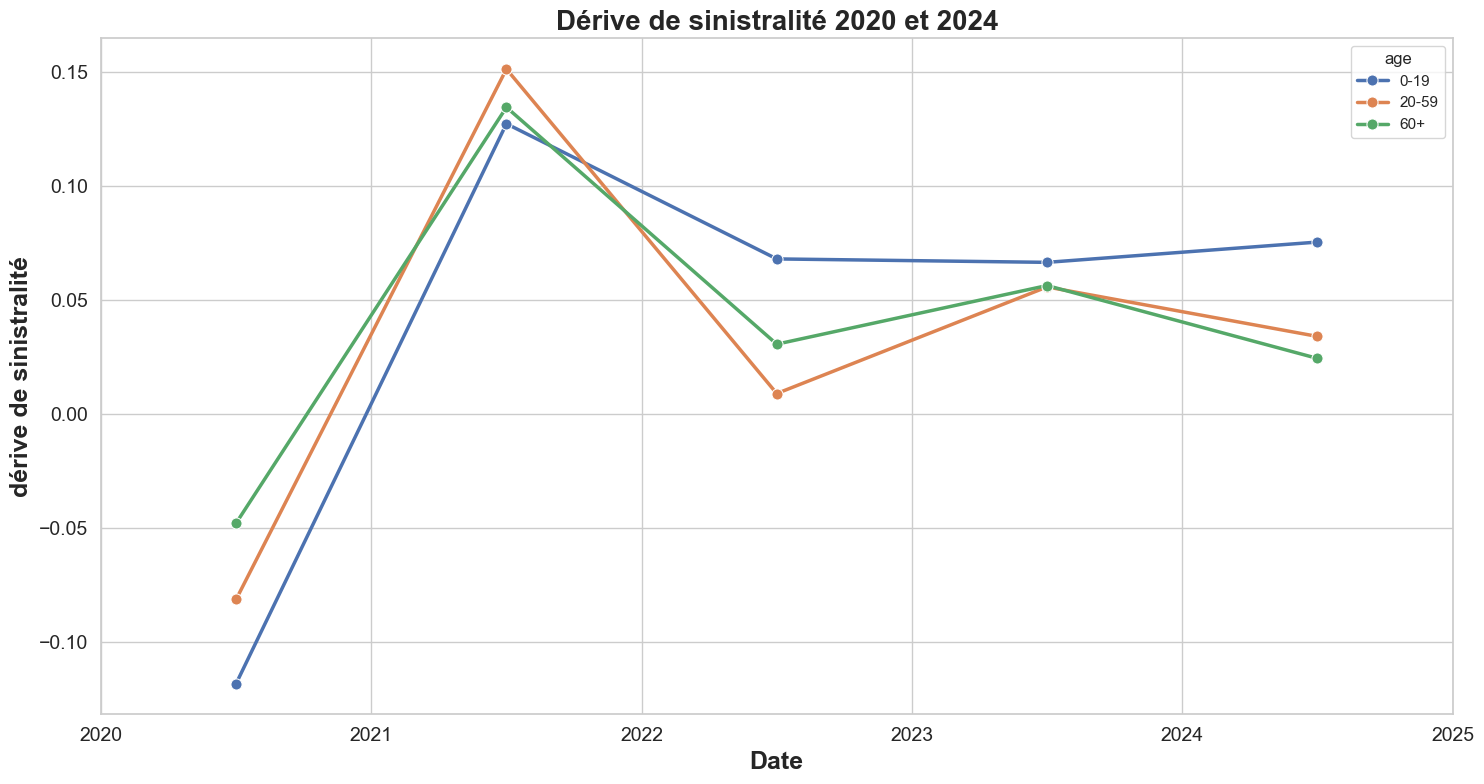

In [207]:
Derive_df = get_all_data_beginning_from_year(2019)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

annees_décalés = Derive_df['annee'] + 0.5
sns.lineplot(x=annees_décalés, y="dérive", data=Derive_df, hue="age", marker='o', markersize=8, linewidth=2.5, errorbar=None)


# Title with bigger font
plt.title("Dérive de sinistralité 2020 et 2024", fontsize=20, fontweight='bold')

# Axis labels with bigger font
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("dérive de sinistralité", fontsize=18, fontweight='bold')

# Optional: Ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlim(2020, 2025)

plt.tight_layout()
plt.show()

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Conception du GLM</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Choix de la loi de probabilité que suit la dérive de sinistralité</b></h2>

In [209]:
def get_hist_from_data_beginning_from_year(year): 
    df = get_all_data_beginning_from_year(year)
    sns.histplot(data=df, x="dérive",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")
    plt.show()
    return 

On va essayer la loi Gamma et effectuer le test d'adéquation de kolmogorov

Estimated mean (μ): 0.03915699400932155
Estimated std dev (σ): 0.07468648807916727


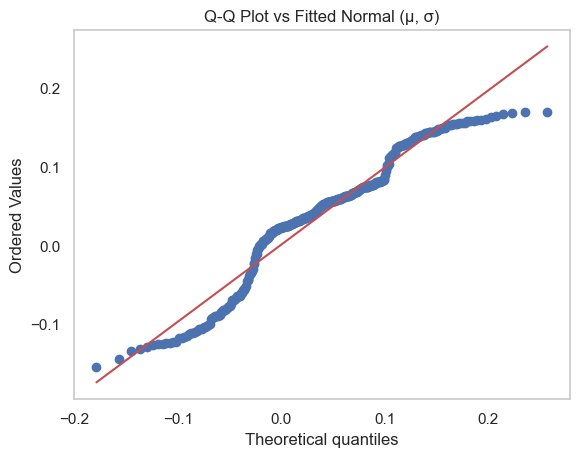

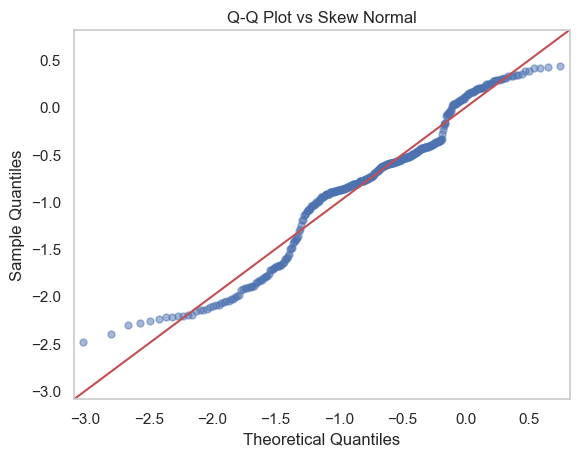

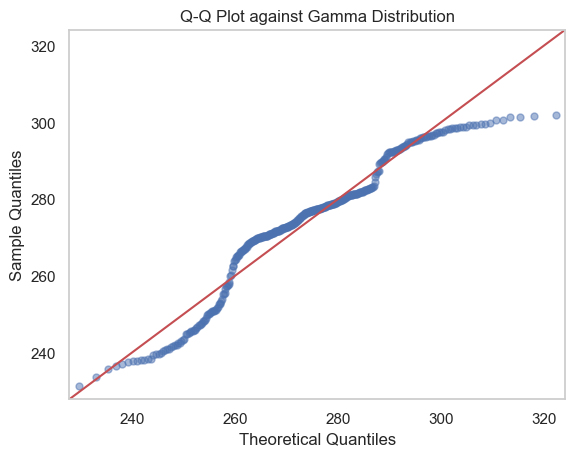

In [194]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt



def get_q_q_plots(year):

    data = get_all_data_beginning_from_year(year)['dérive']

    # Q-Q plot vs normal
    mu, sigma = stats.norm.fit(data)
    print(f"Estimated mean (μ): {mu}")
    print(f"Estimated std dev (σ): {sigma}")

    # Q-Q plot vs skew-normal*
    stats.probplot(data, dist="norm", sparams=(mu, sigma), plot=plt)
    plt.title("Q-Q Plot vs Fitted Normal (μ, σ)")
    plt.grid()
    plt.show()


    # Q-Q plot vs skew-normal
    params = stats.skewnorm.fit(data)
    qqplot(data, dist=stats.skewnorm, distargs=params, line='45',fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot vs Skew Normal")
    plt.grid()
    plt.show()

    # Generate the Q-Q plot
    fig = qqplot(data, dist=stats.gamma, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Gamma Distribution")
    plt.grid()
    plt.show()

    return 

get_q_q_plots(2019)

In [195]:
def GLM_model(year):

    df_GLM = get_all_data_beginning_from_year(year)
    X = pd.get_dummies(df_GLM, columns = ['age', 'sexe', 'region'],drop_first = True,  dtype=int)
    X = sm.add_constant(X)
    y = X['dérive']
    glm_model = sm.GLM(y, sm.add_constant(X.drop(columns=['dérive'])), family=sm.families.Gaussian())  # or another family
    glm_results = glm_model.fit()

    return glm_model, glm_results


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Dans la section suivante, on va chercher l'année à partie de laquelle on obtient un bon modèle GLM</b></h2>



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>À partir de l'année 2019</b></h2>

C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_8276\1702561745.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="dérive",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")


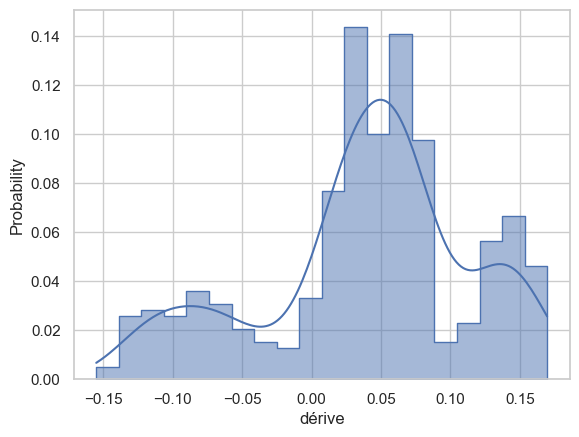

In [210]:
year = 2019
get_hist_from_data_beginning_from_year(year)
glm_model, glm_results = GLM_model(year)

Estimated mean (μ): 0.03915699400932155
Estimated std dev (σ): 0.07468648807916727


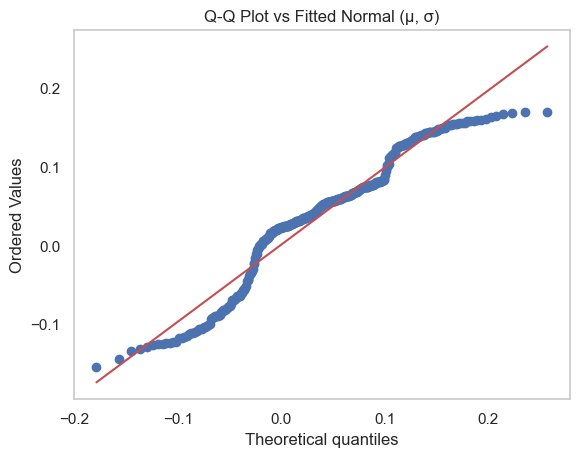

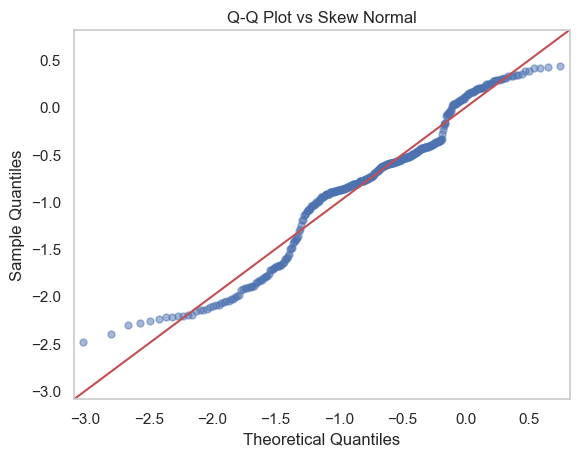

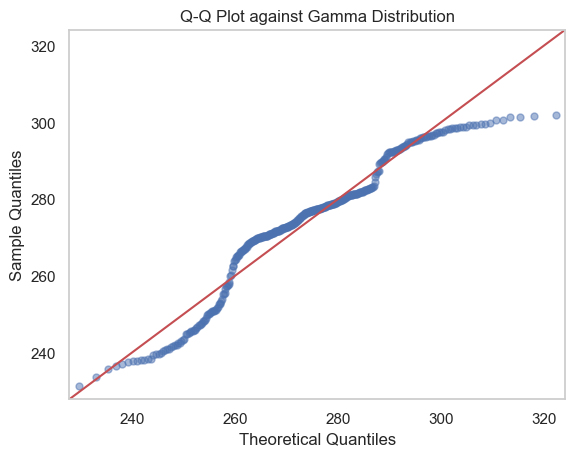

In [197]:
## Get qq plot
get_q_q_plots(year)

In [198]:
# Résultats du model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 dérive   No. Observations:                  390
Model:                            GLM   Df Residuals:                      372
Model Family:                Gaussian   Df Model:                           17
Link Function:               Identity   Scale:                       0.0049546
Method:                          IRLS   Log-Likelihood:                 490.78
Date:                Tue, 29 Apr 2025   Deviance:                       1.8431
Time:                        16:19:02   Pearson chi2:                     1.84
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1589
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.8496      5.191     -6.136      0.0

> Remarque 

On observe que l'histogramme ne suit pas une distribution gaussienne. De plus, il ne s'ajuste pas correctement à une loi de la famille exponentielle (ce qui est nécessaire pour un GLM).  
Ces limitations entraînent un faible coefficient de détermination $R^2 = 0.16$, alors qu'il devrait idéalement être proche de $1$.

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>À partir de l'année 2020</b></h2>

C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_8276\1702561745.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="dérive",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")


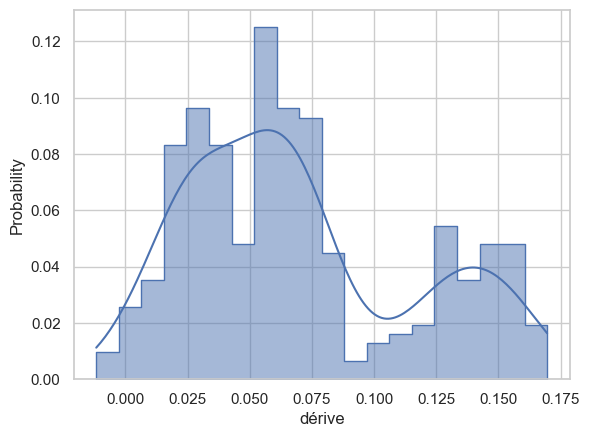

In [211]:
year = 2020
get_hist_from_data_beginning_from_year(year)
glm_model, glm_results = GLM_model(year)

Estimated mean (μ): 0.06956346150547077
Estimated std dev (σ): 0.04539919163969894


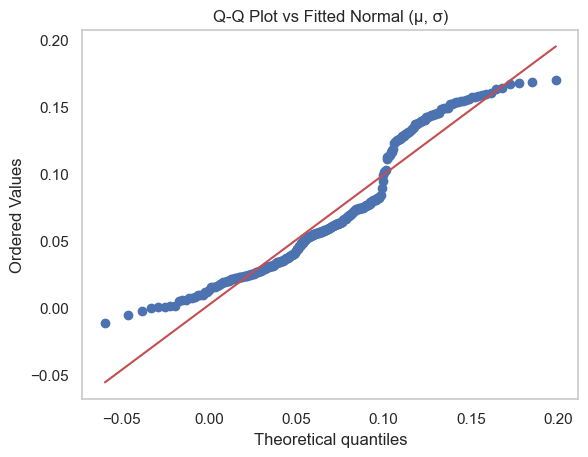

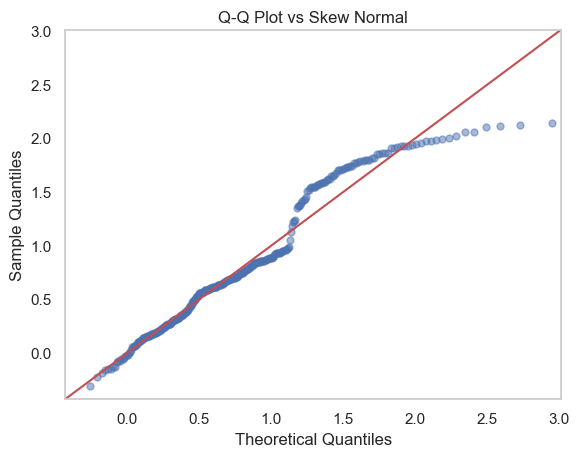

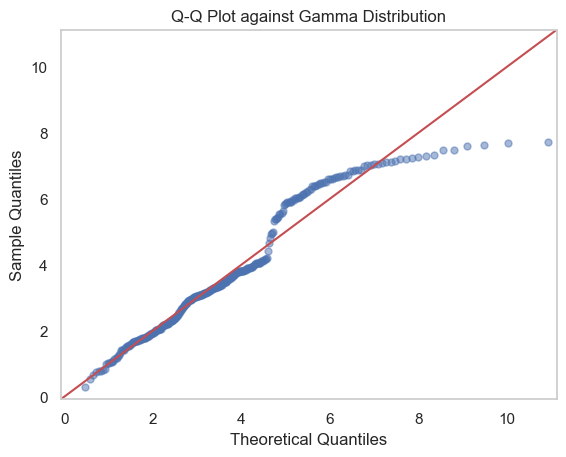

In [200]:
## Get qq plot
get_q_q_plots(year)

In [201]:
# Résultats du modèle
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 dérive   No. Observations:                  312
Model:                            GLM   Df Residuals:                      294
Model Family:                Gaussian   Df Model:                           17
Link Function:               Identity   Scale:                       0.0011704
Method:                          IRLS   Log-Likelihood:                 619.62
Date:                Tue, 29 Apr 2025   Deviance:                      0.34411
Time:                        16:19:04   Pearson chi2:                    0.344
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5597
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6601      3.515     14.698      0.0

> Remarque

Bien que les données ne s'ajustent toujours pas parfaitement à une loi gaussienne, le coefficient de détermination est nettement amélioré avec $R^2 = 0.56$.

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>À partir de l'année 2021</b></h2>

C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_8276\1702561745.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="dérive",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")


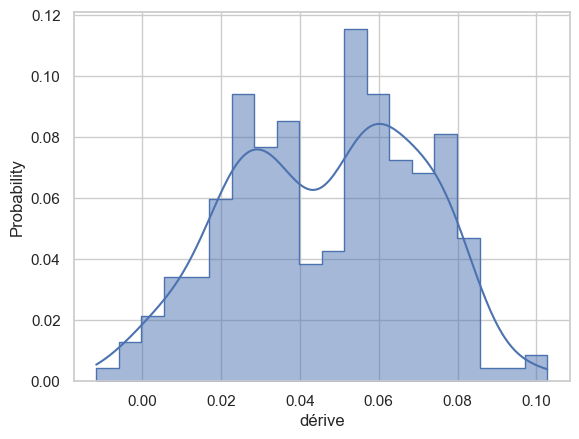

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 dérive   No. Observations:                  234
Model:                            GLM   Df Residuals:                      216
Model Family:                Gaussian   Df Model:                           17
Link Function:               Identity   Scale:                      0.00026603
Method:                          IRLS   Log-Likelihood:                 640.47
Date:                Wed, 30 Apr 2025   Deviance:                     0.057462
Time:                        10:06:10   Pearson chi2:                   0.0575
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6936
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8734      2.648     -3.351      0.0

In [212]:
year = 2021
get_hist_from_data_beginning_from_year(year)
glm_model, glm_results = GLM_model(year)
print(glm_results.summary())

Estimated mean (μ): 0.04678048278814785
Estimated std dev (σ): 0.023652070427114365


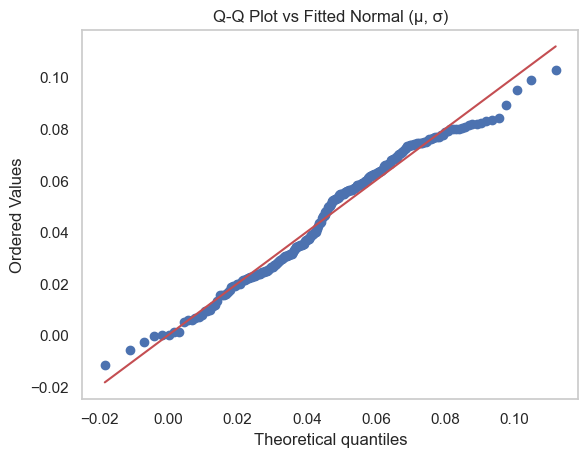

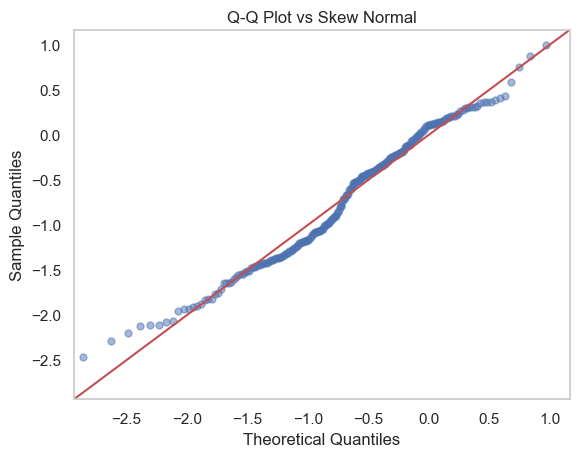

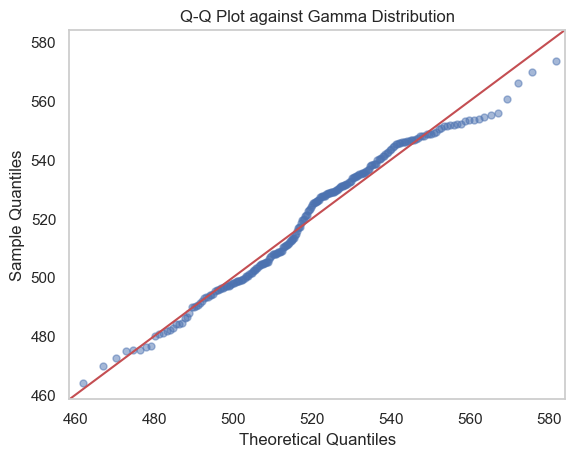

In [203]:
## Get qq plot
get_q_q_plots(year)

### Test d'adéquation de Kolmogorov-Smirnov

In [204]:
from scipy.stats import kstest, norm

# Extract the 'dérive' field
data = get_all_data_beginning_from_year(2021)['dérive']

# Perform the Kolmogorov-Smirnov test for normality
mu, sigma = norm.fit(data)  # Fit a normal distribution to the data
ks_statistic, p_value = kstest(data, 'norm', args=(mu, sigma))

print(f"Statistique de Kolmogorov-Smirnov : {ks_statistic}")
print(f"P-valeur : {p_value}")

if p_value > 0.05:
    print("Les données de dérive à partir de 2021 suivent une distribution normale (on ne rejette pas l'hypothèse nulle).")
else:
    print("Les données ne suivent pas une distribution normale (on rejette l'hypothèse nulle).")

Statistique de Kolmogorov-Smirnov : 0.08433503134965414
P-valeur : 0.06761550935903693
Les données de dérive à partir de 2021 suivent une distribution normale (on ne rejette pas l'hypothèse nulle).


In [205]:
# Résultats du modèle
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 dérive   No. Observations:                  234
Model:                            GLM   Df Residuals:                      216
Model Family:                Gaussian   Df Model:                           17
Link Function:               Identity   Scale:                      0.00026603
Method:                          IRLS   Log-Likelihood:                 640.47
Date:                Tue, 29 Apr 2025   Deviance:                     0.057462
Time:                        16:19:06   Pearson chi2:                   0.0575
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6936
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8734      2.648     -3.351      0.0

> Remarque

Enfin, on trouve un bon ajustement des données avec une loi gaussienne, i.e on retrouve un bon coefficient de détermination $R^2 = 0.7$

### Analyse de coefficients significatif

In [206]:
glm_results.pvalues

const         8.045273e-04
annee         7.150468e-04
population    5.322230e-01
age_20-59     1.493719e-01
age_60+       3.512332e-15
sexe_2        4.310603e-02
region_11     1.294579e-01
region_24     1.458509e-01
region_27     4.113628e-03
region_28     9.210021e-02
region_32     2.246035e-02
region_44     4.684751e-01
region_52     1.540820e-01
region_53     4.208342e-01
region_75     5.687741e-01
region_76     1.894314e-01
region_84     1.365134e-01
region_93     6.299709e-01
dtype: float64

### Résultats des coefficients significatifs du dernier modèle

| **Variable**                          | **Significativité**                     |
|---------------------------------------|-----------------------------------------|
| **annee**                             | ***                 |
| **age_60+**                           | ***                 |
| **sexe_2**                            | *                    |
| **region_27** *(Bourgogne-Franche-Comté)* | ***                 |
| **region_32** *(Hauts-de-France - Nord-Pas-de-Calais-Picardie)* | *  |

#### Légende :
- *** : significativité avec un niveau de confiance de 99%
- \* : significativité avec un niveau de confiance de 95%


### Résultats des coefficients significatifs du dernier modèle

| **Variable**                          | **Significativité**                     |
|---------------------------------------|-----------------------------------------|
| **annee**                             | ***                 |
| **age_60+**                           | ***                 |
| **sexe_2**                            | *                    |
| **region_27** *(Bourgogne-Franche-Comté)* | ***                 |
| **region_32** *(Hauts-de-France - Nord-Pas-de-Calais-Picardie)* | *  |

#### Légende :
- *** : significativité avec un niveau de confiance de 99%
- \* : significativité avec un niveau de confiance de 95%


### Résultats des coefficients significatifs du dernier modèle

| **Variable**                          | **Significativité**                     |
|---------------------------------------|-----------------------------------------|
| **annee**                             | ***                 |
| **age_60+**                           | ***                 |
| **sexe_2**                            | *                    |
| **region_27** *(Bourgogne-Franche-Comté)* | ***                 |
| **region_32** *(Hauts-de-France - Nord-Pas-de-Calais-Picardie)* | *  |

#### Légende :
- *** : significativité avec un niveau de confiance de 99%
- \* : significativité avec un niveau de confiance de 95%
